# British Airlines Project

## Part 1. Collecting data

The data will be obtained from [Skytrax](https://www.airlinequality.com). Let's start composing the script

In [1]:
# import libraries

from bs4 import BeautifulSoup
import requests
import pandas as pd

In [2]:
PAGES_COUNT = 37
PAGE_SIZE = 100
URL = "https://www.airlinequality.com/airline-reviews/british-airways"

page_counter = 0
encountered_error = False
review_data = []
while not encountered_error and page_counter < PAGES_COUNT:
    requested_url = f"{URL}/page/{page_counter + 1}/?sortby=post_date%3ADesc&pagesize={PAGE_SIZE}"
    response = requests.get(requested_url)
    print(f"Requesting page {page_counter + 1} out of {PAGES_COUNT}")
    if response.status_code != 200:
        encountered_error = True
        print(f"Something went wrong!")
        break
    else:
        print("Request is successful!")
        content = BeautifulSoup(response.content, "lxml")
        reviews = content.find_all("div", {"class": "text_content"})
        for review in reviews:
            review_data.append(review.get_text())
        page_counter+=1

Requesting page 1 out of 37
Request is successful!
Requesting page 2 out of 37
Request is successful!
Requesting page 3 out of 37
Request is successful!
Requesting page 4 out of 37
Request is successful!
Requesting page 5 out of 37
Request is successful!
Requesting page 6 out of 37
Request is successful!
Requesting page 7 out of 37
Request is successful!
Requesting page 8 out of 37
Request is successful!
Requesting page 9 out of 37
Request is successful!
Requesting page 10 out of 37
Request is successful!
Requesting page 11 out of 37
Request is successful!
Requesting page 12 out of 37
Request is successful!
Requesting page 13 out of 37
Request is successful!
Requesting page 14 out of 37
Request is successful!
Requesting page 15 out of 37
Request is successful!
Requesting page 16 out of 37
Request is successful!
Requesting page 17 out of 37
Request is successful!
Requesting page 18 out of 37
Request is successful!
Requesting page 19 out of 37
Request is successful!
Requesting page 20 ou

In [3]:
len(review_data)

3602

We got 3602 reviews. Let's see the structure of one of the reviews

In [4]:
review_data[0]

'✅ Trip Verified |  Customer Service does not exist. One world emerald, frequent long haul flyer (including BA) - never seen such poor customer service or “computer says no”. Official BA.com site said all morning and afternoon that flight from Gatwick, delayed 2 hours. Delayed leaving for airport -only for BA to change back to original time. Called BA customer service 1.5 hours prior from highway saying situation - told not to worry, would note and flight rebooked if issue but go to airport. Got to airport 40 mins prior told could not board and that staff did not work for BA so could not help. Back on phone, 3 hours in total to be told could be rebooked, then couldn’t be, round and round. Ultimately told to file complaint. Then found out flight left 2 hours delayed. Paid for extra hotels flights with more competent airlines and now told 38 days wait for complaints to be responded to - heavens help economy and non-status flyers if that’s what the front end of the plane gets!'

Nothing spectecular, just plain text. The "trip verified" part will not be needed, so we'll delete it later. Now let's save the data into csv

In [5]:
review_df = pd.DataFrame({"Review texts":review_data})
review_df.head()

,Review texts
0,✅ Trip Verified | Customer Service does not e...
1,✅ Trip Verified | Another really great pair of...
2,Not Verified | Our A380 developed a fault tax...
3,Not Verified | Horrible airline. Does not care...
4,✅ Trip Verified | My family and I have flown ...


In [6]:
review_df.to_csv("data/reviews.csv", index=False)

## Part 2. EDA with NLP

Having gathered the data, time to analyze it. Loading the data

In [7]:
import pandas as pd

review_df = pd.read_csv("data/reviews.csv")
review_df.head()

,Review texts
0,✅ Trip Verified | Customer Service does not e...
1,✅ Trip Verified | Another really great pair of...
2,Not Verified | Our A380 developed a fault tax...
3,Not Verified | Horrible airline. Does not care...
4,✅ Trip Verified | My family and I have flown ...


### Removing unnecessary part

Earlier we determined that we won't need the "trip verified" part. So we'll delete it in a moment. Also we'll delete any space characters in the beginnig and at the end of each review

In [8]:
review_df["Review texts"] = review_df["Review texts"].str.replace(".*\|", '', regex=True)
review_df["Review texts"] = review_df["Review texts"].str.strip()
review_df.head()

,Review texts
0,Customer Service does not exist. One world eme...
1,"Another really great pair of flights, on time,..."
2,Our A380 developed a fault taxiing to the runw...
3,Horrible airline. Does not care about their cu...
4,My family and I have flown mostly on British A...


Our EDA begins with the most basic stuff - the length of the reviews

In [9]:
review_df["Word count"] = review_df["Review texts"].str.split().map(lambda x: len(x))
review_df.head()

,Review texts,Word count
0,Customer Service does not exist. One world eme...,172
1,"Another really great pair of flights, on time,...",52
2,Our A380 developed a fault taxiing to the runw...,187
3,Horrible airline. Does not care about their cu...,54
4,My family and I have flown mostly on British A...,304


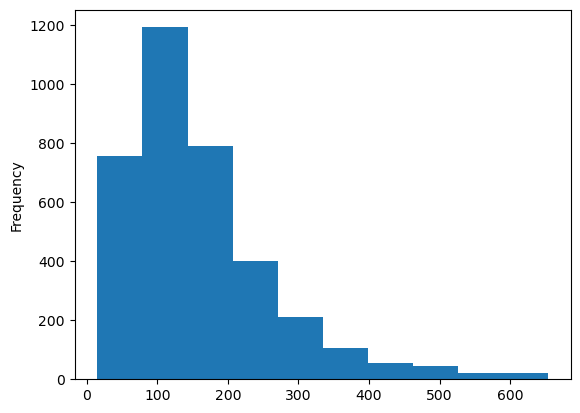

In [11]:
import matplotlib.pyplot as plt

review_df["Word count"].plot.hist()
plt.show()

Most reviews have a word count of 100-150 words, so people don't tend to write long reviews about BA

Right now we have only the word count. What about the most popular words? We'll visualize a word cloud to see the top-100 words people use the most to describe the experience with BA.

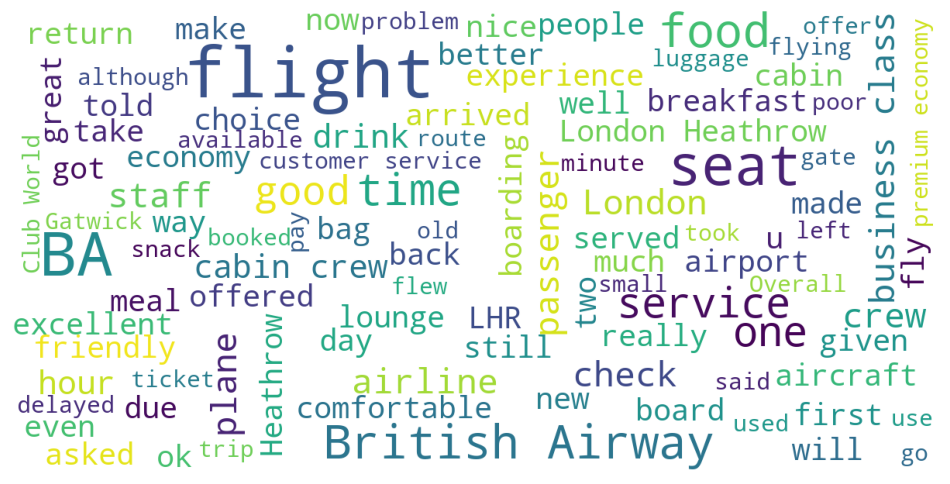

In [18]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=100,
    max_font_size=30,
    scale=3,
    random_state=1)
wordcloud = wordcloud.generate(" ".join(i for i in review_df["Review texts"].to_list()))
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()


The most frequent words are the biggest ones. And they mention the company which is very logical. Next a bit less often service, seats, meals and other aspects are mentioned. Then comes the most interesting part - adjectives. We can see that there are a lot of positive ones - great, nice, ok, excellent, friendly, better, comfortable. But there are still not so good ones - delayed, problem (not an adjective but still negative), old (maybe not that negative), poor.

In conclusion, people tend to write the most about seats, food, service and the flight itself.

Judging from the picture, a hypothesis can be made - there are more positive reviews than negative ones. We'll check that using the sentiment analysis.

The first library we'll use for sentiment analysis is `textblob`. It returns a score from -1 to 1, -1 meaning negative, 1 meaning positive

In [19]:
from textblob import TextBlob

review_df["textblob_sentiment"] = review_df["Review texts"].apply(lambda x: TextBlob(x).sentiment.polarity)
review_df.head()

,Review texts,Word count,textblob_sentiment
0,Customer Service does not exist. One world eme...,172,0.023684
1,"Another really great pair of flights, on time,...",52,0.526970
2,Our A380 developed a fault taxiing to the runw...,187,0.007333
3,Horrible airline. Does not care about their cu...,54,-0.158333
4,My family and I have flown mostly on British A...,304,0.125269


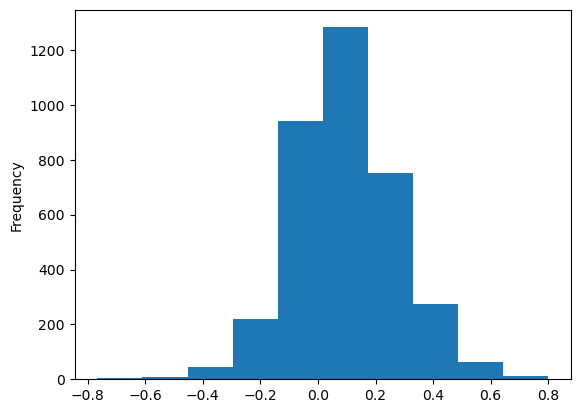

In [21]:
review_df["textblob_sentiment"].plot.hist()
plt.show()

As we can see from the histogram, `textblob` shows that there are more neutral-positive reviews than neutral-negative ones (from -0.1 to 0.3).

And in general, if we look at the far left (<0.3) and far right (>0.3), we can see that positive reviews are still more prevalent. Let's see what the second library - `nltk.sentiment.vader` - has to show

In [23]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


sen_an = SentimentIntensityAnalyzer()
review_df["vader_sentiment"] = review_df["Review texts"].apply(lambda x:sen_an.polarity_scores(x)['compound'])
review_df.head()

,Review texts,Word count,textblob_sentiment,vader_sentiment
0,Customer Service does not exist. One world eme...,172,0.023684,-0.7497
1,"Another really great pair of flights, on time,...",52,0.526970,0.9808
2,Our A380 developed a fault taxiing to the runw...,187,0.007333,-0.6936
3,Horrible airline. Does not care about their cu...,54,-0.158333,-0.7063
4,My family and I have flown mostly on British A...,304,0.125269,0.9190


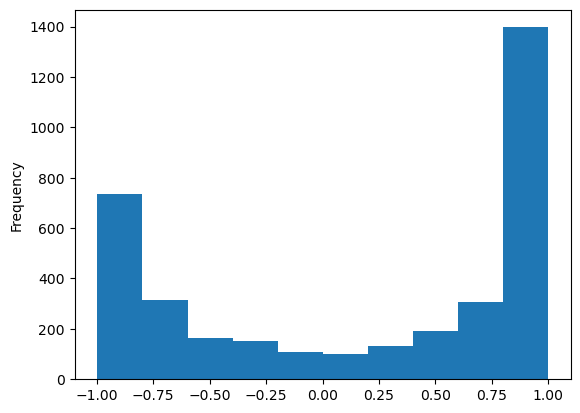

In [24]:
review_df["vader_sentiment"].plot.hist()
plt.show()

VADER is a more categorical than textblob. Yet it also shows that there are approximately twice as many positve reviews than negative ones.

To depict the results more clearly, we'll categorize the reviews using the scores and show their frequencies on a doubled bar chart.

For both of the scores we'll use the same strategy:
- from -0.05 to 0.05 - neutral
- lower than -0.05 - negative
- higher than 0.05 - positive

In [27]:
def score_interpreter(score):
    if -0.05 <= score <= 0.05:
        return "neutral"
    elif score < -0.5:
        return "negative"
    else:
        return "positve"
    
review_df["textblob_category"] = review_df["textblob_sentiment"].apply(score_interpreter)
review_df["vader_category"] = review_df["vader_sentiment"].apply(score_interpreter)
review_df.head()

,Review texts,Word count,textblob_sentiment,vader_sentiment,textblob_category,vader_category
0,Customer Service does not exist. One world eme...,172,0.023684,-0.7497,neutral,negative
1,"Another really great pair of flights, on time,...",52,0.526970,0.9808,positve,positve
2,Our A380 developed a fault taxiing to the runw...,187,0.007333,-0.6936,neutral,negative
3,Horrible airline. Does not care about their cu...,54,-0.158333,-0.7063,positve,negative
4,My family and I have flown mostly on British A...,304,0.125269,0.9190,positve,positve


In [37]:
textblob_counts = review_df.groupby("textblob_category")["Review texts"].count().reset_index()
vader_counts = review_df.groupby("vader_category")["Review texts"].count().reset_index()

In [35]:
textblob_counts

,textblob_category,Review texts
0,negative,7
1,neutral,851
2,positve,2744


In [36]:
vader_counts

,vader_category,Review texts
0,negative,1136
1,neutral,49
2,positve,2417


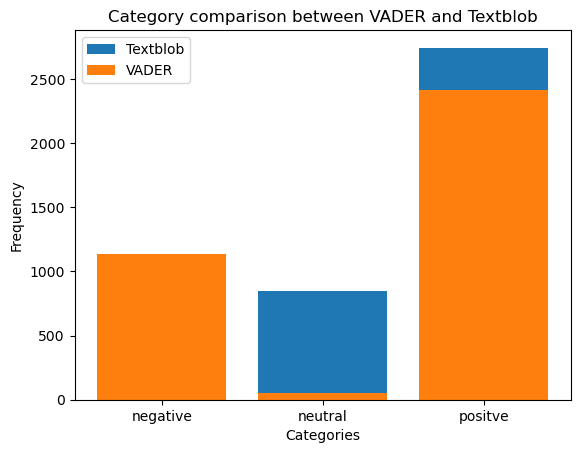

In [38]:
plt.bar(data=textblob_counts, x="textblob_category", height="Review texts", label = 'Textblob')
plt.bar(data=vader_counts, x="vader_category", height="Review texts", label = 'VADER')
  
plt.xlabel("Categories")
plt.ylabel("Frequency")
plt.title("Category comparison between VADER and Textblob")
plt.legend()
plt.show()